In [25]:
import os
import datasets
import numpy as np
import pandas as pd


import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from IPython.display import Audio, display

from sklearn.model_selection import train_test_split

def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

def play_audio(waveform, sample_rate):    
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

In [142]:
class YuemotionDataset(Dataset):
    def __init__(self, data_dir, split="train", transform=None, mix_speakers=True, seed=0):
        """
        data_dir is the path to the folder with all the preprocessed .wav data
        """

        if split not in ["train", "test", "val"]:
            raise ValueError("split should be either train, test or val")

        self.mix_speakers = mix_speakers
        self.seed = seed
        #Build the data folders and sort the preprocessed data into male/female/elderly/non_elderly folders
        self.file_paths = self._build_data_folders(data_dir)
        print(f"Processing the {split} split...")
        train_files, test_files, val_files = self._balanced_split(self.file_paths, self.mix_speakers, self.seed, split_ratio=[0.5, 0.15, 0.35])

        
        #Split
        if split == "train":
            self.files = train_files
            print(f"Done, train split has {len(self.files)} samples.")
        elif split == "test":
            self.files = test_files
            print(f"Done, test split has {len(self.files)} samples.")
        elif split == "val":
            self.files = val_files
            print(f"Done, val split has {len(self.files)} samples.")

        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        filename, extension = os.path.splitext(file)
        filename_data = filename.split("_")

        metadata = {"subject_id": filename_data[0],
                    "gender":("female" if filename_data[1][0]=="f" else "male"),
                    "age": int(filename_data[1][1:]),
                    "elderly_or_not":("elderly" if int(filename_data[1][1:]) >= 59 else "non_elderly"),
                    "sentence_id":filename_data[2],
                    "format":extension}

        audio_path = os.path.join(self.data_dir, metadata["gender"], metadata["elderly_or_not"], file)

        # audio, sample_rate = torchaudio.load(audio_path)
        label = int(filename_data[3])
        # if self.transform:
        #     audio = self.transform(audio)

        metadata["sample_rate"] = 16000
        return {"audio_path": audio_path, "label": label, "metadata":metadata}



    def _balanced_split(self, file_paths, mix_speakers, seed, split_ratio=[0.5, 0.15, 0.35]):
        """
        mix_speakers set to True to have mixed speakers in each split instead of the same ones
        split ratio default is train/val/test 0.5/0.15/0.35
        """

        train_ratio = split_ratio[0]
        val_ratio = split_ratio[1]
        test_ratio = split_ratio[2]

        train_files = []
        test_files = []
        val_files = []

        for key in file_paths.keys():
            cur_files = os.listdir(file_paths[key])
            if mix_speakers:
                train_ratio = split_ratio[0]
                #val_ratio = split_ratio[1]/(1-test_ratio)
                test_ratio = split_ratio[2]/(1-train_ratio)

                data_for_split = np.array([(file, file.split(".")[0][-1]) for file in cur_files])
                cur_train, rest = train_test_split(data_for_split, test_size=split_ratio[0], random_state=seed, stratify=data_for_split[:, 1])
                cur_val, cur_test = train_test_split(rest, test_size=test_ratio, random_state=seed, stratify=rest[:, 1])
                
                cur_train, cur_val, cur_test = cur_train[:, 0], cur_val[:, 0], cur_test[:, 0]
            else:
                cur_train, cur_val, cur_test = np.split(cur_files, [int(len(cur_files)*train_ratio), int(len(cur_files)*(train_ratio+val_ratio))])
            train_files.extend(cur_train.tolist())
            test_files.extend(cur_test.tolist())
            val_files.extend(cur_val.tolist())

        return train_files, test_files, val_files

    def _build_data_folders(self, data_dir):

        def _mkdir(path):
            if not os.path.isdir(path):
                os.makedirs(path)

        #Build all the relevant data folders
        male_path = os.path.join(data_dir, "male")
        _mkdir(male_path)
        female_path = os.path.join(data_dir, "female")
        _mkdir(female_path)

        male_elderly_path = os.path.join(male_path, "elderly")
        _mkdir(male_elderly_path)
        male_non_elderly_path = os.path.join(male_path, "non_elderly")
        _mkdir(male_non_elderly_path)
        female_elderly_path = os.path.join(female_path, "elderly")
        _mkdir(female_elderly_path)
        female_non_elderly_path = os.path.join(female_path, "non_elderly")
        _mkdir(female_non_elderly_path)

        file_paths = {"male_elderly_path":male_elderly_path,
                      "male_non_elderly_path":male_non_elderly_path,
                      "female_elderly_path":female_elderly_path,
                      "female_non_elderly_path":female_non_elderly_path}

        #Sort all the .wav files into relevant folders
        files = os.listdir(data_dir)
        for file in files:
            
            if "male" in file or "female" in file:
                #Already built
                continue

            metadata = file.split("_")
            age = metadata[1][1:]
            gender = metadata[1][0]
            cur_path = os.path.join(data_dir, file)

            if gender == "m":
                if int(age) >= 59:
                    new_path = os.path.join(male_elderly_path, file)
                    os.rename(cur_path, new_path)

                elif int(age) < 59:
                    new_path = os.path.join(male_non_elderly_path, file)
                    os.rename(cur_path, new_path)

            elif gender == "f":
                if int(age) >= 59:
                    new_path = os.path.join(female_elderly_path, file)
                    os.rename(cur_path, new_path)

                elif int(age) < 59:
                    new_path = os.path.join(female_non_elderly_path, file)
                    os.rename(cur_path, new_path)

            else:
                raise ValueError(f"The file {file} doesn't have the correct name formatting")
        
        file_paths = {"male_elderly_path":male_elderly_path,
                      "male_non_elderly_path":male_non_elderly_path,
                      "female_elderly_path":female_elderly_path,
                      "female_non_elderly_path":female_non_elderly_path}

        return file_paths



    # def plot_waveform(self, idx):

    #     data = self.__getitem__(idx)
    #     waveform = data["audio"]
    #     sample_rate = data["metadata"]["sample_rate"]
        
    #     waveform = waveform.numpy()

    #     num_channels, num_frames = waveform.shape
    #     time_axis = torch.arange(0, num_frames) / sample_rate

    #     figure, axes = plt.subplots(num_channels, 1)
    #     if num_channels == 1:
    #         axes = [axes]
    #     for c in range(num_channels):
    #         axes[c].plot(time_axis, waveform[c], linewidth=1)
    #         axes[c].grid(True)
    #         if num_channels > 1:
    #             axes[c].set_ylabel(f"Channel {c+1}")
    #     figure.suptitle("waveform")
    #     plt.show(block=False)



    def play_audio(self, idx):
        """
        Only works in notebook
        """
        data = self.__getitem__(idx)
        waveform = data["audio"]
        sample_rate = data["metadata"]["sample_rate"]
        
        waveform = waveform.numpy()

        num_channels, num_frames = waveform.shape
        if num_channels == 1:
            display(Audio(waveform[0], rate=sample_rate))
        elif num_channels == 2:
            display(Audio((waveform[0], waveform[1]), rate=sample_rate))
        else:
            raise ValueError("Waveform with more than 2 channels are not supported.")


def collate_fn(batch):

    audios = [torch.squeeze(sample["audio"], dim=0) for sample in batch]
    labels = [int(sample["label"]) for sample in batch]
    longest = max([len(audio) for audio in audios])
    audios = np.stack([np.pad(audio, (0, longest - len(audio))) for audio in audios])
    audios = np.expand_dims(audios, axis=1)
    return torch.from_numpy(audios), torch.tensor(labels)

def transform(audio):
    ##If needed TO-DO
    ##Are those the usually used transformation in speech? https://pytorch.org/audio/stable/transforms.html
    ##FrequencyMasking, TimeMasking and TimeStretch?
    pass

data_dir = "/home/willy/nora_mrp/yuemotion/preprocessed/Yuemotion"

train_data = YuemotionDataset(data_dir, split="train", seed=0, mix_speakers=True)
val_data = YuemotionDataset(data_dir, split="val", seed=0, mix_speakers=True)
test_data = YuemotionDataset(data_dir, split="test", seed=0, mix_speakers=True)
all_data = YuemotionDataset(data_dir, split="all")
# train_dataloader = DataLoader(train_data, batch_size=16, shuffle=False, collate_fn=collate_fn)
# val_dataloader = DataLoader(val_data, batch_size=16, shuffle=False, collate_fn=collate_fn)
# test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

Processing the train split...
Done, train split has 540 samples.
Processing the val split...
Done, val split has 162 samples.
Processing the test split...
Done, test split has 378 samples.


ValueError: split should be either train, test or val

In [14]:
all_data[0]

{'audio': tensor([[-5.1880e-04, -8.8501e-04, -6.1035e-05,  ..., -4.2725e-04,
           2.1667e-03,  6.7139e-04]]),
 'label': '6',
 'metadata': {'subject_id': '15',
  'gender': 'male',
  'age': '62',
  'elderly_or_not': 'elderly',
  'sentence_id': '10',
  'format': '.wav',
  'sample_rate': 16000,
  'audio_path': 'yuemotion/preprocessed/male/elderly/15_m62_10_6.wav'}}

In [151]:
#from yuemotion import YuemotionDataset

def load_yuemotion(dataset_path):
    label_dict = {"1": "angry",
                  "2": "happiness",
                  "3": "sadness",
                  "4": "neutral",
                  "5": "fear",
                  "6": "disgust"}
    data_dict = {
        "audio": [],
        "age": [],
        "gender": [],
        "lang": [],
        "age_group": [],
        "split":[],
        # "sentence_id": [],
        # "subject_id": [],
    }
    data_dict.update({emotion: [] for emotion in label_dict.values()})
    #If no split, use split=all
    #yuemotion_all = YuemotionDataset(dataset_path, split="all")
    yuemotion_train =  YuemotionDataset(os.path.join(dataset_path, "Yuemotion"), split="train", mix_speakers=True, seed=0)
    yuemotion_test = YuemotionDataset(os.path.join(dataset_path, "Yuemotion"), split="test", mix_speakers=True, seed=0)
    yuemotion_val = YuemotionDataset(os.path.join(dataset_path, "Yuemotion"), split="val", mix_speakers=True, seed=0)
    dataset_splits = {"train": yuemotion_train,
                      "test": yuemotion_test,
                      "val": yuemotion_val}

    for split in dataset_splits:
        dataset = dataset_splits[split]
        for sample in dataset:
            data_dict["age"].append(sample["metadata"]["age"])
            data_dict["gender"].append(sample["metadata"]["gender"])
            data_dict["audio"].append(sample["audio_path"])
            if sample["metadata"]["elderly_or_not"] == "elderly":
                data_dict["age_group"].append("elderly")
            else:
                data_dict["age_group"].append("others")
            # data_dict["sentence_id"].append(sample["metadata"]["sentence_id"])
            # data_dict["subject_id"].append(sample["metadata"]["subject_id"])
            data_dict["split"].append(split)
            data_dict["lang"].append("yue")
            

            label = sample["label"]
            for emotion in label_dict.values():
                if emotion == label_dict[str(label)]:
                    data_dict[emotion].append(1)
                else:
                    data_dict[emotion].append(0)

    yuemotion_df = pd.DataFrame(data_dict)
    return yuemotion_df
    


In [149]:
yuemotion_df_no_mix = load_yuemotion("/home/willy/nora_mrp/yuemotion/preprocessed")

Processing the train split...
Done, train split has 540 samples.
Processing the test split...
Done, test split has 378 samples.
Processing the val split...
Done, val split has 162 samples.


In [152]:
yuemotion_df_with_mix = load_yuemotion("/home/willy/nora_mrp/yuemotion/preprocessed")

Processing the train split...
Done, train split has 540 samples.
Processing the test split...
Done, test split has 378 samples.
Processing the val split...
Done, val split has 162 samples.


In [157]:
print(yuemotion_df_with_mix[yuemotion_df_with_mix["split"]=="val"]["angry"].sum())
print(yuemotion_df_with_mix[yuemotion_df_with_mix["split"]=="val"]["happiness"].sum())
print(yuemotion_df_with_mix[yuemotion_df_with_mix["split"]=="val"]["sadness"].sum())
print(yuemotion_df_with_mix[yuemotion_df_with_mix["split"]=="val"]["neutral"].sum())
print(yuemotion_df_with_mix[yuemotion_df_with_mix["split"]=="val"]["fear"].sum())
print(yuemotion_df_with_mix[yuemotion_df_with_mix["split"]=="val"]["disgust"].sum())

26
28
28
26
26
28


In [158]:
print(yuemotion_df_no_mix[yuemotion_df_no_mix["split"]=="val"]["angry"].sum())
print(yuemotion_df_no_mix[yuemotion_df_no_mix["split"]=="val"]["happiness"].sum())
print(yuemotion_df_no_mix[yuemotion_df_no_mix["split"]=="val"]["sadness"].sum())
print(yuemotion_df_no_mix[yuemotion_df_no_mix["split"]=="val"]["neutral"].sum())
print(yuemotion_df_no_mix[yuemotion_df_no_mix["split"]=="val"]["fear"].sum())
print(yuemotion_df_no_mix[yuemotion_df_no_mix["split"]=="val"]["disgust"].sum())

16
26
36
28
29
27


In [18]:
yuemotion_df.loc[(yuemotion_df['lang'] == 'yue') & (yuemotion_df['age_group'] == 'elderly')]

,audio,age,gender,lang,age_group,split,sentence_id,subject_id,angry,happiness,sadness,neutral,fear,disgust
0,/home/willy/nora_mrp/yuemotion/preprocessed/ma...,62,male,yue,elderly,train,10,15,0,0,0,0,0,1
1,/home/willy/nora_mrp/yuemotion/preprocessed/ma...,62,male,yue,elderly,train,04,15,0,0,0,1,0,0
2,/home/willy/nora_mrp/yuemotion/preprocessed/ma...,62,male,yue,elderly,train,08,15,0,0,0,0,0,1
3,/home/willy/nora_mrp/yuemotion/preprocessed/ma...,60,male,yue,elderly,train,04,14,0,0,0,0,1,0
4,/home/willy/nora_mrp/yuemotion/preprocessed/ma...,60,male,yue,elderly,train,08,14,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,/home/willy/nora_mrp/yuemotion/preprocessed/fe...,66,female,yue,elderly,val,07,11,0,0,0,0,0,1
1013,/home/willy/nora_mrp/yuemotion/preprocessed/fe...,60,female,yue,elderly,val,08,17,0,0,0,1,0,0
1014,/home/willy/nora_mrp/yuemotion/preprocessed/fe...,60,female,yue,elderly,val,03,18,0,1,0,0,0,0
1015,/home/willy/nora_mrp/yuemotion/preprocessed/fe...,60,female,yue,elderly,val,07,17,0,0,1,0,0,0


In [5]:
train_data

In [7]:
train_data[5]

{'audio': tensor([[-0.0014, -0.0025, -0.0023,  ..., -0.0010, -0.0012, -0.0013]]),
 'label': '5',
 'metadata': {'subject_id': '15',
  'gender': 'male',
  'age': '62',
  'elderly_or_not': 'elderly',
  'sentence_id': '05',
  'format': '.wav',
  'sample_rate': 16000,
  'audio_path': 'yuemotion/preprocessed/male/elderly/15_m62_05_5.wav'}}

In [8]:
train_data.play_audio(5)

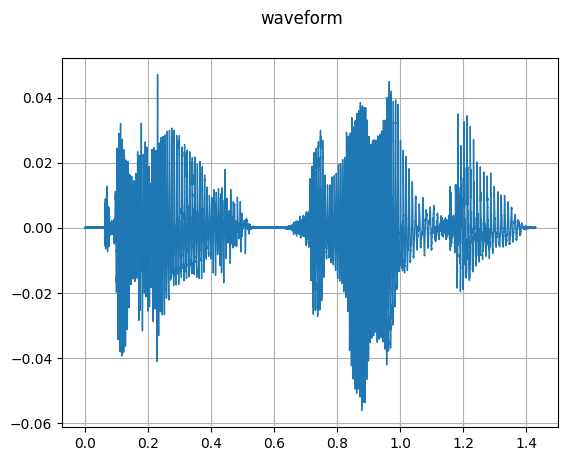

In [50]:
train_data.plot_waveform(5)

In [236]:
sample = next(iter(train_dataloader))

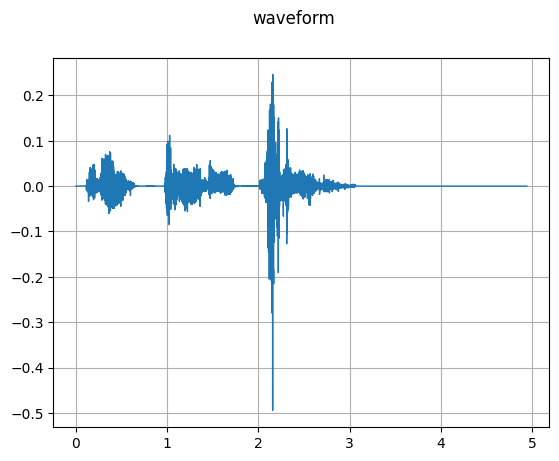

In [231]:
plot_waveform(sample[0][1], 16000)

In [212]:
play_audio(sample[0][1], 16000)